# Comparing Neighbourhoods on Apartments
This notebook compares and clusters different neighbourhoods based on apartment living standards. Three scores are used to compare apartments and the neighbourhoods: apartment evaluation score, walking score, and neighbourhood safety score. The apartment evaluation score has been conducted by the Apartment Building Standards. The walking score will be calculated by measuring the distance between the apartment and nearby venues. The neighbourhood safety score will be determined by the number of crimes that occurred close to the neighbourhood.

In [1]:
#%pip install geocoder
#%pip install bs4
#%pip install geopy

In [2]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup

import geocoder
import folium
import re

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

import math
from math import cos, asin, sqrt
from scipy import stats

### **Extract Neighbourhood data**
Extract postal code data from Wikipedia and location data from csv file ('Geospatial_Coordinates.csv'). Clean dataframe and select neighbourhoods within Toronto only.

In [3]:
# using beautifulsoup to web parse table
url = urllib.request.urlopen("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
html = url.read()

soup = BeautifulSoup(html, 'html.parser')

table=[]
htmltable = soup.table.find_all('tr')
table.append([th.get_text(strip=True) for th in htmltable[0].find_all('th')])
for line in htmltable[1:]:
    row = [td.get_text(strip=True) for td in line.find_all('td')]
    table.append(row)
df = pd.DataFrame(table[1:], columns=table[0])
df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


In [4]:
# remove 'Borough's that are not assigned and group same postcodes
df = df[df['Borough'] != 'Not assigned']
group = df.groupby(['Postcode']).count()
indices = group.index

In [5]:
# clean dataframe to merge same post codes into one row
clean_df = pd.DataFrame(columns = df.columns)

for index in indices:
    num_neigh = group.loc[index,'Neighbourhood']
    neighbourhoods = []
    for i in range(0, num_neigh):
        neighbourhoods.append(df[df['Postcode'] == index]['Neighbourhood'].iloc[i])
        neighbourhood = ', '.join(neighbourhoods)
    clean_df = clean_df.append({'Postcode': index, 'Borough': df[df['Postcode'] == index]['Borough'].iloc[0], 'Neighbourhood': neighbourhood},ignore_index=True)
clean_df.columns  = ['PostalCode', 'Borough', 'Neighbourhood']

In [6]:
# change neighbourhoods names that are not assigned to their respective borough name
for i in range(0,clean_df.shape[0]):
    if clean_df['Neighbourhood'].iloc[i] == 'Not assigned':
        clean_df['Neighbourhood'].iloc[i] = clean_df['Borough'].iloc[i]

In [7]:
# read csv of geospatial coordinates 
coords = pd.read_csv('Geospatial_Coordinates.csv')

In [8]:
# add latitude and longitude values to the exisiting Toronto neighbourhood dataframe
clean_df['Latitude'] = ""
clean_df['Longitude'] = ""
for postcode in clean_df['PostalCode']:
    clean_df['Latitude'].loc[clean_df['PostalCode'] ==  postcode] =\
        coords[coords['Postal Code'] == postcode].reset_index().loc[0,'Latitude']
    clean_df['Longitude'].loc[clean_df['PostalCode'] ==  postcode] = \
        coords[coords['Postal Code'] == postcode].reset_index().loc[0,'Longitude']

In [9]:
# rename dataframe to toronto_df
toronto_df = clean_df.copy()

In [10]:
# find the coordinates of the center of all neighbourhoods, assuming the average latitude and longitude are centers
avg_lat = toronto_df['Latitude'].mean()
avg_lng = toronto_df['Longitude'].mean()

### **Extract Crime Data for Neighbourhoods**
Find the crime data of each neighbhourhood (from Toronto Police Service). The neighbourhood center coordinates which are closest to the crime location will be the neighbourhood that the crime occurred in. Select only 10% of the crimes that occurred to manage data (16752 crimes).

In [11]:
crime = pd.read_csv('toronto_crime_list.csv')

In [12]:
# function to calculate distance between two points
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...

In [13]:
# create new column for crime count
toronto_df['Crime'] = 0

In [14]:
# count crime for each neighbourhood based on the distance between the crime location and the closest neighbourhood
for ind in np.arange(16752):
    min_dist = 1000
    for toronto_ind in np.arange(toronto_df.shape[0]):
        dist = distance(crime.loc[ind,'Y'], crime.loc[ind,'X'], toronto_df.loc[toronto_ind,'Latitude'], toronto_df.loc[toronto_ind, 'Longitude'])
        if dist < min_dist:
            neigh = toronto_ind
            min_dist = dist
    toronto_df.loc[neigh,'Crime'] += 1

In [15]:
# calculate crime score based on max and min number of crimes per neighbourhood
toronto_df['CRIME_SCORE'] = 1 - ((toronto_df['Crime'] - np.min(toronto_df['Crime']))/ \
                                          (np.max(toronto_df['Crime']) - np.min(toronto_df['Crime'])))

### **Extract data on apartments**
Obtained from Toronto Open Data Portal. Data consists of apartment address and apartment evaluation scores (by Apartment Building Standards).

In [16]:
apartments = pd.read_csv('Apartment Building Evaluation.csv')

In [17]:
apartments = apartments[['SCORE', 'SITE_ADDRESS','YEAR_BUILT']]
apartments.columns = ['APART_EVAL_SCORE', 'SITE_ADDRESS', 'YEAR_BUILT']

There are 3450 apartments in the dataset, which is too large to process. We want to limit the search to newer apartments built after 1975, but first we need to check if there will be bias in neighbourhoods on the age of the apartments. We will segment the apartments based on their age and plot on a graph.

In [18]:
# create geocode that extracts location paramters and postal codes from address
locator = Nominatim(user_agent="myGeocoder")
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.5)

In [19]:
for ind in np.arange(100): #select first 100 apartments in list
    try:
        add = geocode(apartments['SITE_ADDRESS'][ind] + ', TORONTO, CANADA')
        apartments.loc[ind,'POSTAL_CODE'] = re.search('M\d[A-Z]\s\d[A-Z]\d', add[0])[0][0:3]
        apartments.loc[ind,'LATITUDE'] = add.point[0]
        apartments.loc[ind,'LONGITUDE'] = add.point[1]
    except:
        None
    
    if ind % 50 == 0:
        print(ind)

# remove any apartments where address could not be obtained
hundred_apartments = apartments.iloc[0:].copy()
hundred_apartments.dropna(axis=0, inplace=True)

0
50


RateLimiter caught an error, retrying (0/2 tries). Called with (*('54  THORNCLIFFE PARK DR , TORONTO, CANADA',), **{}).
Traceback (most recent call last):
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 964

In [20]:
# apartment age [less than 20, 20-39, 40-59, 60-79, 80+]
age = [0, 20, 40, 60, 80]

Here, the first 100 apartments are labeled on the map, segmented based on their age. We can qualitatively observe that there is not clear grouping of apartment age by neighbourhood and we can make conclusions about neighbourhoods based on only newer apartments.

In [21]:
# create map about neighbourhood center 
map_apartments = folium.Map(location=[avg_lat, avg_lng], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(len(age))
ys = [i + x + (i*x)**2 for i in range(len(age))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, year in zip(hundred_apartments['LATITUDE'],\
                          hundred_apartments['LONGITUDE'],\
                          hundred_apartments['YEAR_BUILT']):
    age_group = math.floor((2020- year)/20)
    if age_group > 4:
        age_group = 4
        label = 'Building Age: {}0+'.format(2*age_group)
    else:
        label = 'Building Age: {}0 - {}0'.format(2*age_group, 2*age_group + 2)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=rainbow[age_group],
        fill=True,
        fill_color=rainbow[age_group],
        fill_opacity=0.7,
        parse_thml=False).add_to(map_apartments)
    
map_apartments

Now that the distribution of apartment age was confirmed to be uniform across neighbourhoods, select apartments only built after 1975 to create a dataset that is much more manageable (504 rows).

In [22]:
# select only new apartments with built year above 1975
new_apartments = apartments[apartments['YEAR_BUILT'] > 1975].reset_index().copy()
new_apartments.drop(columns='index', inplace=True)

# add new columns for location details
new_apartments['POSTAL_CODE'] = np.nan
new_apartments['LATITUDE'] = np.nan
new_apartments['LONGITUDE'] = np.nan

In [23]:
new_apartments

,APART_EVAL_SCORE,SITE_ADDRESS,YEAR_BUILT,POSTAL_CODE,LATITUDE,LONGITUDE
0,82.0,763 WOODBINE AVE,2016.0,NaN,NaN,NaN
1,93.0,1544 DUNDAS ST W,2016.0,NaN,NaN,NaN
2,92.0,12 BROADWAY AVE,1993.0,NaN,NaN,NaN
3,79.0,585 KING ST E,1980.0,NaN,NaN,NaN
4,81.0,2755 YONGE ST,1990.0,NaN,NaN,NaN
...,...,...,...,...,...,...
499,53.0,841 QUEEN ST E,1988.0,NaN,NaN,NaN
500,81.0,101 ONTARIO ST,2005.0,NaN,NaN,NaN
501,68.0,310 DUNDAS ST E,1980.0,NaN,NaN,NaN
502,83.0,4300 BATHURST ST,1989.0,NaN,NaN,NaN


In [24]:
# find the location coordinates and postal code based on address 
for ind in np.arange(new_apartments.shape[0]): #new_apartments.shape[0]
    try:
        add = geocode(new_apartments['SITE_ADDRESS'][ind] + ', TORONTO, CANADA')
        new_apartments.loc[ind,'POSTAL_CODE'] = re.search('M\d[A-Z]\s\d[A-Z]\d', add[0])[0][0:3]
        new_apartments.loc[ind,'LATITUDE'] = add.point[0]
        new_apartments.loc[ind,'LONGITUDE'] = add.point[1]
    except:
        None
    
    if ind % 50 == 0:
        print(ind)

# remove any apartments where address details could not be obtained
new_apartments.dropna(axis=0, inplace=True)
new_apartments.head(20)

0
50
100
150
200
250
300
350
400
450
500


,APART_EVAL_SCORE,SITE_ADDRESS,YEAR_BUILT,POSTAL_CODE,LATITUDE,LONGITUDE
0,82.0,763 WOODBINE AVE,2016.0,M4L,43.680649,-79.310493
1,93.0,1544 DUNDAS ST W,2016.0,M6K,43.649988,-79.433387
2,92.0,12 BROADWAY AVE,1993.0,M4P,43.709907,-79.398223
3,79.0,585 KING ST E,1980.0,M5A,43.656388,-79.356677
4,81.0,2755 YONGE ST,1990.0,M4N,43.718293,-79.400218
5,63.0,81 GILDER DR,1980.0,M1K,43.736940,-79.254020
6,79.0,1401 DUPONT ST,2006.0,M6H,43.666548,-79.446636
8,95.0,925 BAY ST,2005.0,M5S,43.664178,-79.386612
9,58.0,325 GERRARD ST E,1980.0,M5A,43.662053,-79.365910
10,68.0,520 KINGSTON RD,1992.0,M4L,43.677926,-79.302024


### **Foursquare to extract nearby venues**
Use Foursquare to explore what venues are nearby the apartment and give a "Walking Score" for each apartment, depending on how close amenities are to the building. A radius of 1000 m is used as an appropriate distance an adult is likely to walk (10-15 minutes).

In [25]:
# foursquare credentials
CLIENT_ID = 'QU1KZFASAM4ERLKP4YISVFNNBPUHGRWH3OH5OKHOYAIX0HVV' # your Foursquare ID
CLIENT_SECRET = 'ZFG3BCTRZ2JJVS1UIO0BF1OMSHQ1M3OG103D0Y5A3JVKV2SP' # your Foursquare Secret
VERSION = '20190206' # Foursquare API version

#### Define Walking Score
Max 100 score and takes into account three categories: proximity to grocery store, proximity to restaurants, and proximity to transit.  
**Grocery Score**  
grocery_score = 1 - (dist_to_nearest_store in km) * 0.3  
**Restaurant Score**  
restaurant_score = 1 - (avg_dist_to_restaurants in km) /  (number_of_restaurants_in_radius) / 0.2  
**Transit Score**  
transit_score = 1 - (dist_to_nearest_train_station in km) * 0.1  
  
**Walking Score**  
walking_score = avg(grocery_score, restaurant_score, transit_score)

In [26]:
# read the train station list of Toronto with coordinates
stations = pd.read_csv('Toronto_stations.csv')
stations['Distance'] =  np.nan

In [27]:
# find walking score of each apartment
def get_walking_score(lats, lngs):
    n=0
    walking_score = []
    for lat, lng in zip(lats, lngs):
        # initialize variables
        restaurant_dist = 0
        num_restaurant = 0  
        grocery_dist = [1]
        transit_dist = [1]
        # url
        apartment_latitude = lat
        apartment_longitude = lng
        LIMIT = 100
        radius = 1000
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}\
        &client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
                .format(CLIENT_ID, CLIENT_SECRET, VERSION, \
                apartment_latitude, apartment_longitude, radius, LIMIT)

        # retrieve data from foursquare about nearby venues
        results = requests.get(url).json()

        # clean venues list
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues) # flatten JSON
        
        # find restaurants and the distance between apartment
        restaurant_words = ['Pizza', 'Bar', 'Diner', 'Burger', 'Sandwich', 'Breakfast',\
                            'Bakery', 'Coffee', 'Caf', 'Pub', 'Restaurant']
        
        for i in range(0, nearby_venues.shape[0]):
            if any(x in nearby_venues['venue.categories'].iloc[i][0]['name']\
                   for x in restaurant_words):
                restaurant_dist += distance(lat, lng,\
                                            nearby_venues['venue.location.lat'].iloc[i],\
                                            nearby_venues['venue.location.lng'].iloc[i])
                num_restaurant += 1
        if num_restaurant == 0:
            restaurant_score=0
        else:
            restaurant_score = (1-(restaurant_dist / num_restaurant ** 2) / 0.2)
        
        # find closest grocery and distance to apartment
        grocery_words = ['Grocery', 'Supermarket']      
        for i in range(0, nearby_venues.shape[0]):
            if any(x in nearby_venues['venue.categories'].iloc[i][0]['name']\
                   for x in grocery_words):
                grocery_dist.append(distance(lat, lng,\
                                            nearby_venues['venue.location.lat'].iloc[i],\
                                            nearby_venues['venue.location.lng'].iloc[i]))
            

        grocery_score = (1 - min(grocery_dist) *  0.3)
        
        
        # find closest train station
        for sta_ind in np.arange(stations.shape[0]):
            stations.loc[sta_ind,'Distance'] = distance(lat, lng,
                                                       stations.loc[sta_ind,'Latitude'],
                                                       stations.loc[sta_ind,'Longitude'])
        transit_dist = min(stations.Distance)

        transit_score = (1 - transit_dist *  0.1)
        
        walking_score.append([np.average([grocery_score, restaurant_score, transit_score]),grocery_score, restaurant_score, transit_score])        

        n+=1
        
        if n%50== 0:
            print(n)
    return(walking_score)

In [28]:
# create new columns for scores
new_apartments['WALKING_SCORE'] = 0
new_apartments['GROCERY_SCORE'] = 0
new_apartments['REST_SCORE'] = 0
new_apartments['TRANS_SCORE'] = 0

# get scores
walking_score = get_walking_score(new_apartments['LATITUDE'], new_apartments['LONGITUDE'])
new_apartments.loc[:,['WALKING_SCORE', 'GROCERY_SCORE', 'REST_SCORE','TRANS_SCORE']] = walking_score

50
100
150
200
250
300
350
400
450


In [29]:
# combine the neighbourhood dataframe (toronto_df) with the apartment dataframe grouped by neighbourhood
toronto_df.columns= ['POSTAL_CODE'] + list(toronto_df.columns[1:])     #rename column to be consistent with new_apartments dataframe
neighbourhood_score = new_apartments[['APART_EVAL_SCORE', 'WALKING_SCORE','POSTAL_CODE']].groupby('POSTAL_CODE').mean()
neighbourhood_score = pd.merge(neighbourhood_score, toronto_df, on='POSTAL_CODE')

### **Clustering**
Cluster using the apartment score, walking score, and crime score as parameters to group neighbourhoods by their characteristics. Use the elbow method to check what k to use. A k of 3 or 4 seems to be where the distortion decrease seems to slow down. For this case, four clusters are used to segment the neighbourhoods.

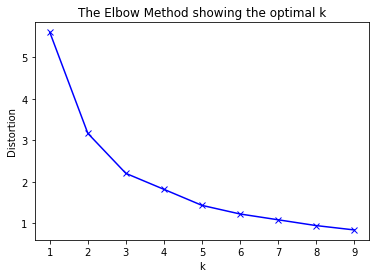

In [31]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

neighbourhood_score_clustering = neighbourhood_score[['APART_EVAL_SCORE', 'WALKING_SCORE', 'CRIME_SCORE']]

# k means determine k
distortions = []
kclusters = range(1,10)
for k in kclusters:
    kmeans = KMeans(n_clusters=k,  random_state=0).fit(neighbourhood_score_clustering)
    distortions.append(sum(np.min(cdist(neighbourhood_score_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) \
                       / neighbourhood_score_clustering.shape[0])

# Plot the elbow
plt.plot(kclusters, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [32]:
# k-means clustering

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhood_score_clustering)

# check cluster labels generated for each row in the dataframe
neighbourhood_score['labels'] = kmeans.labels_

In [33]:
neighbourhood_score.reset_index()

,index,POSTAL_CODE,APART_EVAL_SCORE,WALKING_SCORE,Borough,Neighbourhood,Latitude,Longitude,Crime,CRIME_SCORE,labels
0,0,M1B,77.545455,0.485293,Scarborough,"Rouge, Malvern",43.8067,-79.1944,277,0.437882,0
1,1,M1E,79.400000,0.197423,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887,291,0.409369,3
2,2,M1G,70.000000,0.560609,Scarborough,Woburn,43.771,-79.2169,200,0.594705,2
3,3,M1H,77.250000,0.455275,Scarborough,Cedarbrae,43.7731,-79.2395,220,0.553971,0
4,4,M1J,85.500000,0.689189,Scarborough,Scarborough Village,43.7447,-79.2395,370,0.248473,3
...,...,...,...,...,...,...,...,...,...,...,...
76,76,M9N,85.000000,0.638134,York,Weston,43.7069,-79.5182,231,0.531568,3
77,77,M9P,83.333333,0.647087,Etobicoke,Westmount,43.6963,-79.5322,85,0.828921,3
78,78,M9R,79.500000,0.654970,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.6889,-79.5547,211,0.572301,3
79,79,M9V,70.666667,0.235241,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.7394,-79.5884,479,0.026477,2


In [34]:
# create map about neighbourhood center 
map_clusters = folium.Map(location=[avg_lat, avg_lng], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, neighbourhood, cluster in zip(neighbourhood_score['Latitude'],\
                                           neighbourhood_score['Longitude'],\
                                           neighbourhood_score['Neighbourhood'],\
                                           neighbourhood_score['labels']):
    label = '{}, Cluster: {}'.format(neighbourhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7,
        parse_thml=False).add_to(map_clusters)
    
map_clusters

#### **Difference Between Clusters**
To check what the main difference between the different clusters are, the average building evaluation score, walking score, and crime score were determined.  
**Cluster 0 (purple)**  
* Located mainly near downtown area
* Low apartment evaluation score, best walking score, average crime score
* Great for people who have top priority in proximity to necessities  

**Cluster 1 (light blue)**
* Located mainly near central north area
* Best apartment evaluation score, okay walking score, high crime score
* Great for people who have top priority in safety and building quality and don't mind walking further or driving  

**Cluster 2 (yellow)**  
* Located mainly on west side of city
* Worst apartment evaluation score, worst walking score, and worst crime score
* Use caution when renting in these neighbourhoods and ensure the apartment building and location are safe  

**Cluster 3 (red)**
* Located mainly east side of city
* Average scores for all parameters
* Good neighbourhood for well rounded apartments

In [35]:
neighbourhood_score[['APART_EVAL_SCORE', 'WALKING_SCORE', 'CRIME_SCORE', 'labels']].groupby('labels').mean()

,APART_EVAL_SCORE,WALKING_SCORE,CRIME_SCORE
labels,,,
0,76.292449,0.806414,0.604277
1,90.044103,0.748808,0.745961
2,70.040923,0.721358,0.565937
3,82.090099,0.744695,0.650407


In [36]:
neighbourhood_score[['APART_EVAL_SCORE', 'WALKING_SCORE', 'CRIME_SCORE', 'labels']].groupby('labels').std()

,APART_EVAL_SCORE,WALKING_SCORE,CRIME_SCORE
labels,,,
0,1.658234,0.145820,0.231220
1,2.613443,0.155883,0.134658
2,2.576406,0.186474,0.218807
3,2.267039,0.168537,0.163814
